# Movie Content Based Recommendation System
---
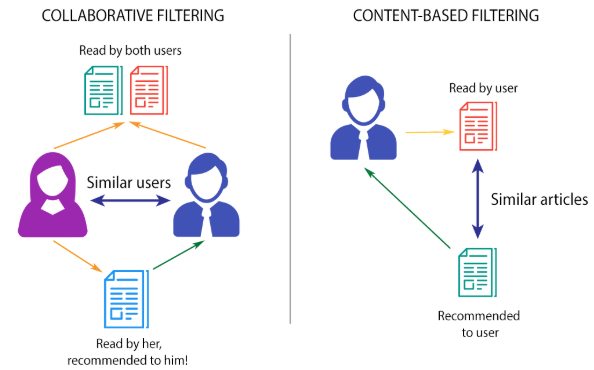

## Importing Required Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
from urllib.request import urlretrieve

## Importing the Dataset
> The Dataset has been downloaded from **Kaggle** datasets
> <br>
> The Dataset Url: https://www.kaggle.com/tmdb/tmdb-movie-metadata

In [ ]:
!pip install opendatasets --upgrade --q
import opendatasets as od

od.download('https://www.kaggle.com/tmdb/tmdb-movie-metadata?select=tmdb_5000_movies.csv')
od.download('https://www.kaggle.com/tmdb/tmdb-movie-metadata?select=tmdb_5000_credits.csv')

In [13]:
movies = pd.read_csv('./tmdb-movie-metadata/tmdb_5000_movies.csv')
credits = pd.read_csv('./tmdb-movie-metadata/tmdb_5000_credits.csv')

## Exploratory Data Analysis

In [14]:
credits.head()

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [16]:
movies.head(2)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500


In [17]:
print("Credits: ", credits.shape)
print("Movies: ", movies.shape)

Credits:  (4803, 4)
Movies:  (4803, 20)


> Let's merge the two datasets based on the features `movie_id` and `id`

In [21]:
credits_renamed = credits.rename(columns={'movie_id': 'id'})
movies_credits = movies.merge(credits_renamed, on = 'id')
movies_credits.head(2)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title_x,vote_average,vote_count,title_y,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."


In [23]:
merged_cleaned_df = movies_credits.drop(columns=['homepage', 'title_x', 'title_y', 'status','production_countries'])
merged_cleaned_df.head(2)

,budget,genres,id,keywords,original_language,original_title,overview,popularity,production_companies,release_date,revenue,runtime,spoken_languages,tagline,vote_average,vote_count,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Enter the World of Pandora.,7.2,11800,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]","At the end of the world, the adventure begins.",6.9,4500,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."


In [24]:
merged_cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4803 entries, 0 to 4802
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   id                    4803 non-null   int64  
 3   keywords              4803 non-null   object 
 4   original_language     4803 non-null   object 
 5   original_title        4803 non-null   object 
 6   overview              4800 non-null   object 
 7   popularity            4803 non-null   float64
 8   production_companies  4803 non-null   object 
 9   release_date          4802 non-null   object 
 10  revenue               4803 non-null   int64  
 11  runtime               4801 non-null   float64
 12  spoken_languages      4803 non-null   object 
 13  tagline               3959 non-null   object 
 14  vote_average          4803 non-null   float64
 15  vote_count           

> ## Content Based Recommendation System
Now lets make recommendations based on the movie’s plot summaries given in the overview column. So if our user gives us a movie title, our goal is to recommend movies that share similar plot summaries.

In [25]:
merged_cleaned_df.head(1)['overview']

0    In the 22nd century, a paraplegic Marine is di...
Name: overview, dtype: object

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfv = TfidfVectorizer(min_df=3, max_features=None, strip_accents='unicode', analyzer='word', 
                      token_pattern='\w{1,}', ngram_range=(1, 3), stop_words='english')

# Filling NaNs with empty string
merged_cleaned_df['overview'] = merged_cleaned_df['overview'].fillna('')

In [28]:
# Fitting 'TF-IDF' on the 'overview' test
tfv_matrix = tfv.fit_transform(merged_cleaned_df['overview'])

In [29]:
tfv_matrix

<4803x10417 sparse matrix of type '<class 'numpy.float64'>'
	with 127220 stored elements in Compressed Sparse Row format>

In [30]:
tfv_matrix.shape

(4803, 10417)

In [31]:
from sklearn.metrics.pairwise import sigmoid_kernel

# Compute the Sigmoid kernel
sig = sigmoid_kernel(tfv_matrix, tfv_matrix)

In [32]:
sig[0]

array([0.76163447, 0.76159416, 0.76159416, ..., 0.76159416, 0.76159416,
       0.76159416])

In [42]:
# Reverse mapping of indices and movie titles
indices = pd.Series(merged_cleaned_df.index, index=merged_cleaned_df['original_title']).drop_duplicates()

In [43]:
indices

original_title
Avatar                                         0
Pirates of the Caribbean: At World's End       1
Spectre                                        2
The Dark Knight Rises                          3
John Carter                                    4
                                            ... 
El Mariachi                                 4798
Newlyweds                                   4799
Signed, Sealed, Delivered                   4800
Shanghai Calling                            4801
My Date with Drew                           4802
Length: 4803, dtype: int64

In [48]:
indices['Newlyweds']

4799

In [45]:
sig[4799]

array([0.76159416, 0.76159416, 0.76159438, ..., 0.76159432, 0.76159416,
       0.76159478])

In [ ]:
list(enumerate(sig[indices['Newlyweds']]))

In [49]:
def give_rec(title, sig=sig):
    # Get the index corresponding to original_title
    idx = indices[title]

    # Get the pairwise similarity scores
    sig_scores = list(enumerate(sig[idx]))

    # Sort the movies
    sig_scores = sorted(sig_scores, key=lambda x: x[1], reverse=True)

    # Scores of the 10 most similar movies
    sig_scores = sig_scores[1:11]

    # Movie indices
    movie_indices = [i[0] for i in sig_scores]

    # Top 10 most similar movies
    return merged_cleaned_df['original_title'].iloc[movie_indices]

In [53]:
# Testing our content-based recommendation system with the seminal film `Spy Kids`
give_rec('Spy Kids')

1302    Spy Kids 2: The Island of Lost Dreams
1155                  Spy Kids 3-D: Game Over
1769      Spy Kids: All the Time in the World
4044                               Go for It!
3359                              In Too Deep
1631                                 Mr. 3000
1825                Jimmy Neutron: Boy Genius
339                           The Incredibles
3793                     The Velocity of Gary
1081                       Revolutionary Road
Name: original_title, dtype: object